# Deep Learning for Beginners - Programming Exercises

by Aline Sindel, Katharina Breininger and Tobias Würfl

Pattern Recognition Lab, Friedrich-Alexander-University Erlangen-Nürnberg, Erlangen, Germany 
## Introduction

Neural networks, especially convolutional neural networks (CNNs), have had an incredible impact on research in medical imaging and medical signal processing in recent years. Deep learning frameworks like PyTorch, TensorFlow, and Caffe make it easy to implement network architectures to carry out experiments by simply stacking together operators. This has helped to speed up research immensely - it is easy to try out new ideas and translate insights from other fields. BUT: Never having to understand the technical details of the frameworks and operators deprives researchers of one avenue to potential innovation in the field. Improvements like trainable region-proposals and depth-wise separable convolutions are easier to come up with a thorough understanding in the details of the machinery. Many essential advances in deep learning, such as the ReLU, batch normalization and better initialization strategies, have originated in understanding and improving drawbacks of building blocks in neural networks.

In the programming exercises, we aim to support you in understanding what's going on inside neural network frameworks, and teach you how the most common operators work during inference in a network and how they are adapted by training. This will enable you to implement a broader range of ideas, relying on innovative new operators embedded into neural networks. 

- How it works:
    - We provide the necessary math and code skeletons of building blocks
    - You translate this math into code
    - Our unit-tests will give you feedback on the correctness of your implementation
    - At the end, we will put these building blocks together to a working network
- Tasks
    - Signal processing with fast Fourier transform
    - Image filtering and edge detection
    - Implementing a multilayer perceptron framework
    - Extending this framework with state-of-the-art initialization
    - Adding the basic operators of CNNs
    - Including some operators for regularization to the framework
    - Implementing one basic neural network architecture for classification
    

Have fun!

# Exercise 1



In [17]:
# minor set-up work
import numpy as np  # we will definitely need this

import unittest

# automatic reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft
from scipy.io.wavfile import write
from audioplayer import AudioPlayer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Signal processing with fast Fourier transform

The Fourier transform has a diverse set of applications in the fields of signal, image, and video processing. The Fourier transform decomposes a function into its frequency components. According to the Fourier inversion theorem, there is also an inverse Fourier transform that mathematically reconstructs the original function (time domain) from its frequency domain representation.
In this exercise, we will implement a small example for using the fast Fourier transform to reduce the noise in an audio signal. First, we generate two sine waves, one with the frequency of tone A (440 Hz) and the other of tone C (262 Hz). The Fourier series are defined that all periodic signals can be expressed in terms of a linear combination of cosine and sine functions. So, let's sum up both tones to generate the mixed tone of A and C.


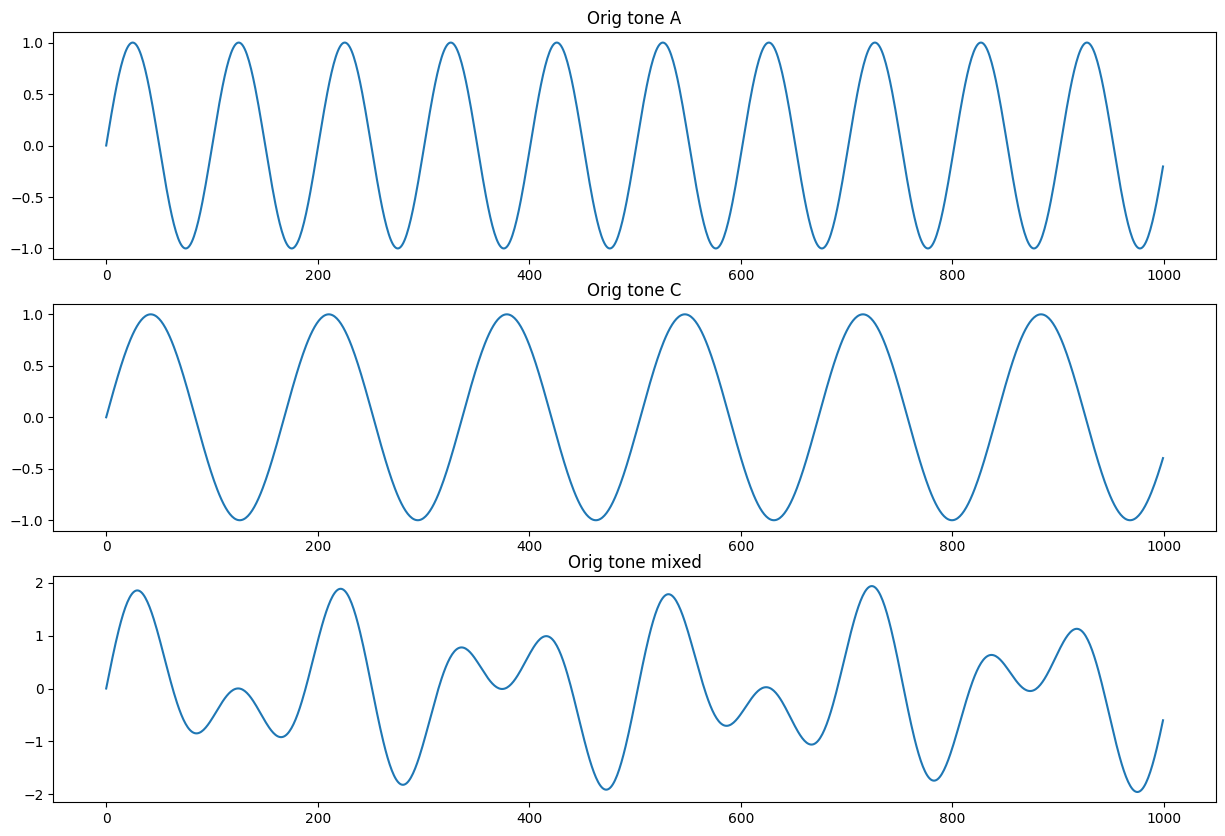

In [21]:
# %load src/filtering/signal_basics.py
def generate_tone(freq, sampling_rate, time):
    x = np.linspace(0, time, sampling_rate * time, endpoint=False)
    y = np.sin((2 * np.pi) * x * freq)
    return x, y

#set parameters for signals
sampling_rate = 44100 # hertz
t = 2  # seconds
s = 1000 #for plotting only a subset

#generate sine wave tones
x, tone_A = generate_tone(440, sampling_rate, t)
x, tone_C = generate_tone(262, sampling_rate, t)

#addition of both signals
tone_mix = tone_A  + tone_C

#plotting
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(3,1,1)
plt.plot(tone_A[:s])
plt.title("Orig tone A")
fig.add_subplot(3,1,2)
plt.plot(tone_C[:s])
plt.title("Orig tone C")
fig.add_subplot(3,1,3)
plt.plot(tone_mix[:s])
plt.title("Orig tone mixed")
plt.show()



### Implementation task

**Now it is your turn**: (1) Compute the fast Fourier transform (FFT) of the mixed signal and the inverse fast Fourier transform (IFFT). You should be able to reconstruct the original signal. As a hint, use the ```rfft``` and ```irfft``` function from ```scipy.fft```. (2) As a next step, we add some noise to the signal. Now, compute the FFT and (3) filter out the noise in the Fourier domain. You will clearly see the noise by comparing the Fourier domain representation of the original signal and the noisy signal. Applying thresholding in the Fourier domain should be sufficient to reduce the noise. (4) Then, apply the IFFT to reconstruct a noise reduced signal that should sound like the original one. You can visually and acoustically compare your denoised signal with the original one in the last cell of this exercise.

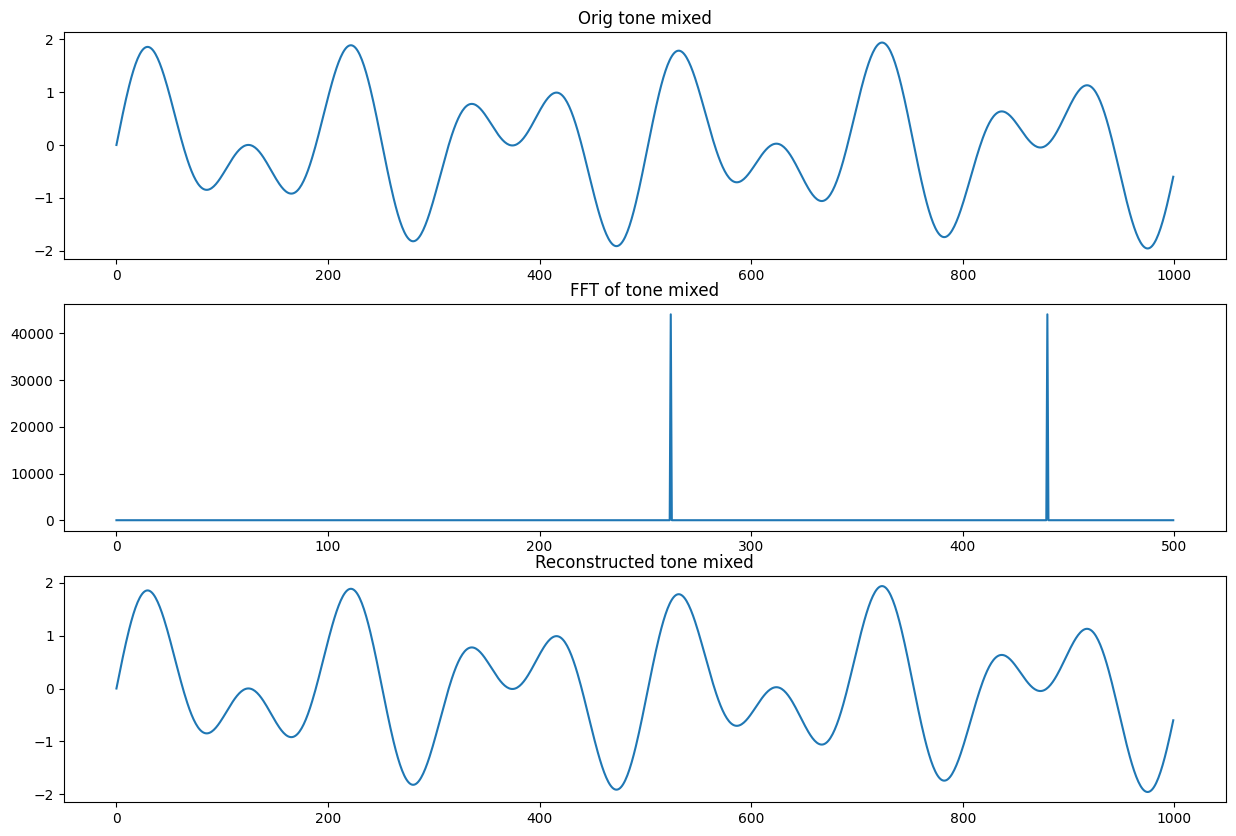

In [23]:
# %writefile src/filtering/fft_step1.py
# %load src/filtering/fft_step1_0.py
#----------------------------------
# Exercise: fast Fourier transform Step 1
#----------------------------------
# The original python file can be reloaded by typing %load src/filtering/fft_step1_0.py in the first line of this cell.
# After successfully solving this exercise, type the following command in the first line of this cell:
# %%writefile src/filtering/fft_step1.py
# This will save the result to a python file, which you will need for the next exercises.

#Step 1:
# Compute the fast Fourier transform (FFT) of the mixed signal, hint: Use the rfft 
yf = rfft(tone_mix)

# sample frequencies of FFT
N = sampling_rate * t
xf = rfftfreq(N, 1 / sampling_rate)

#Compute the inverse fast Fourier transform (IFFT)
reco_tone = irfft(yf)

#plotting
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(3,1,1)
plt.plot(tone_mix[:s])
plt.title("Orig tone mixed")
fig.add_subplot(3,1,2)
plt.plot(xf[:s],np.abs(yf)[:s])
plt.title("FFT of tone mixed")
fig.add_subplot(3,1,3)
plt.plot(reco_tone[:s])
plt.title("Reconstructed tone mixed")
plt.show()

In [5]:
# Running the testsuite
class Difference(unittest.TestCase):
    def test_difference(self):
        diff = reco_tone - tone_mix
        self.assertAlmostEqual(diff.sum(), 0)        
unittest.main(argv=['first-arg-is-ignored'], verbosity=2, exit=False)       

test_difference (__main__.Difference) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


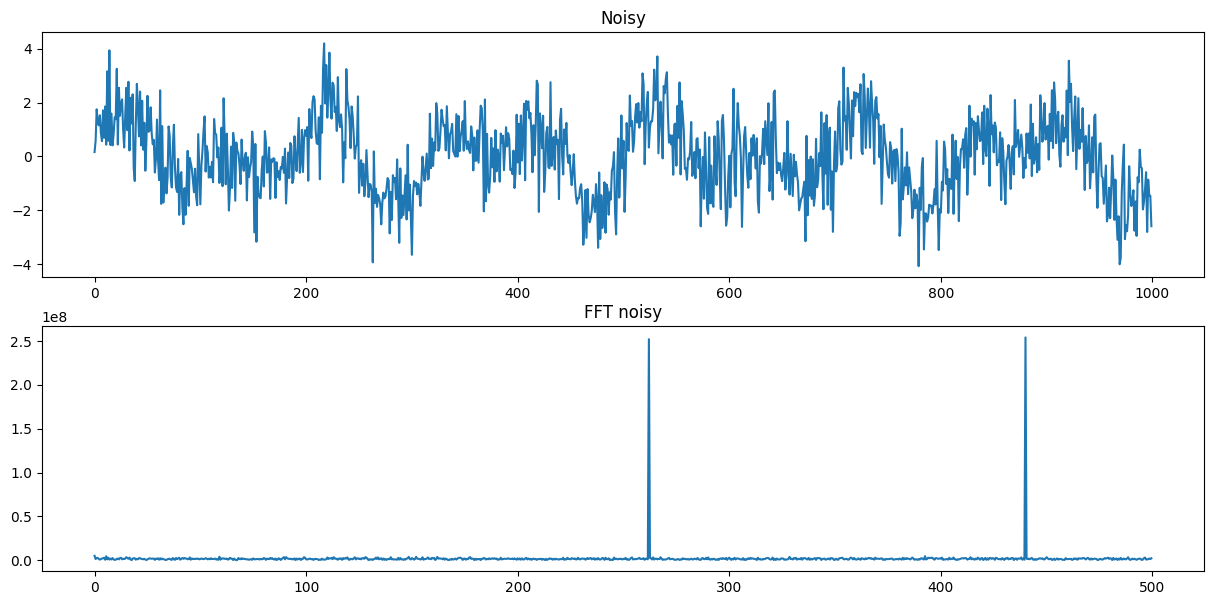

In [25]:
# %load src/filtering/fft_step2_0.py
#----------------------------------
# Exercise: fast Fourier transform Step 2
#----------------------------------
# The original python file can be reloaded by typing %load src/filtering/fft_step2_0.py in the first line of this cell.
# After successfully solving this exercise, type the following command in the first line of this cell:
# %%writefile src/filtering/fft_step2.py
# This will save the result to a python file, which you will need for the next exercises.

#Step 2:
#add noise to the signal
tone_noisy = tone_mix + np.random.randn(len(x))

#save sounds to disk
norm_tone_mix = np.int16((tone_mix / tone_mix.max()) * 32767)
norm_tone_noisy = np.int16((tone_noisy / tone_noisy.max()) * 32767)
write("orig.wav", sampling_rate, norm_tone_mix)
write("noisy.wav", sampling_rate, norm_tone_noisy)

# compute the FFT of the noisy signal
yf = rfft(norm_tone_noisy)

# Number of samples in normalized_tone
N = sampling_rate * t
xf = rfftfreq(N, 1 / sampling_rate)

#plotting
fig = plt.figure(figsize=(15, 7))
fig.add_subplot(2,1,1)
plt.plot(tone_noisy[:s])
plt.title("Noisy")
fig.add_subplot(2,1,2)
plt.plot(xf[:s], np.abs(yf)[:s])
plt.title("FFT noisy")
plt.show()

In [28]:
# %load src/filtering/fft_step3and4_0.py
#----------------------------------
# Exercise: fast Fourier transform Step 3 and 4
#----------------------------------
# The original python file can be reloaded by typing %load src/filtering/fft_step3and4_0.py in the first line of this cell.
# After successfully solving this exercise, type the following command in the first line of this cell:
# %%writefile src/filtering/fft_step3and4.py
# This will save the result to a python file, which you will need for the next exercises.

#Step 3:
#filtering the noisy signal in the fourier domain: 
#Hint: compute a threshold based on the magnitude of the fourier representation (absolute value) that only restores the two peaks
print(norm_tone_noisy)
yf_clean = rfft()

#Step 4:
#compute the inverse fast Fourier transform
filtered_tone = irfft(yf_clean)

#store filtered tone to disk
norm_filtered_tone = np.int16(filtered_tone * (32767 / filtered_tone.max()))
write("clean.wav", sampling_rate, norm_filtered_tone)

#plotting
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(3,1,1)
plt.plot(xf[:s], np.abs(yf_clean)[:s])
plt.title("FFT filtered")
fig.add_subplot(3,1,2)
plt.plot(filtered_tone[:s])
plt.title("Reconstructed filtered tone mixed")
fig.add_subplot(3,1,3)
plt.plot(tone_mix[:s])
plt.title("Original tone mixed")
plt.show()

UsageError: Line magic function `%writefile` not found (But cell magic `%%writefile` exists, did you mean that instead?).


In [ ]:
# Running the testsuite
class Difference(unittest.TestCase):
    def test_difference(self):
        diff = filtered_tone - tone_mix
        self.assertAlmostEqual(diff.sum(), 0)
        
unittest.main(argv=['first-arg-is-ignored'], verbosity=2, exit=False)   

In [ ]:
#play the tone with added noise (mix of tone A and tone C and noise)
AudioPlayer("noisy.wav").play(block=True)

In [ ]:
#play the original tone (mix of tone A and tone C)
AudioPlayer("orig.wav").play(block=True)

In [ ]:
#play the filtered tone (your noise reduced signal)
AudioPlayer("clean.wav").play(block=True)